# Differential power analysis

This type of Side Channel Attack was introduced by Paul Kocher et. al. in [DPA](https://paulkocher.com/doc/DifferentialPowerAnalysis.pdf) paper using DES algorithm as an example. Authors notice that there is significant difference of power consumption depending on the **values** that are being processed within DES algorithm. Important part of DPA is **selection function**. That is the function that is used for separating data into two different sets. For DES, selection function D(C,b,Ks) is defined as calculating value of bit b at the round 16 of the DES computation. 

The attacker observer some large number of crypto operations, makes a key guess Ks and evaluates the average of the function D on all of the traces. In other words, point-by-point average traces are calculated for:

1. traces that have a value of 1 for bit b
2. traces that have a value of 0 for bit b

Difference between these two traces is observed.

If the key guess Ks was incorrect, there is 50/50 chance that value of D matches the actual bit b of the target. This means that there is no correlation between D and the actual target values. Additionaly, if difference of these two avarage traces were to be plotted, it would appear flat. On the other hand, if the attacker correctly guessed Ks, value of the function D will **always** match the actual target bit b. This means that the plot would show spikes wherever there is strong correlation between D and the target values.

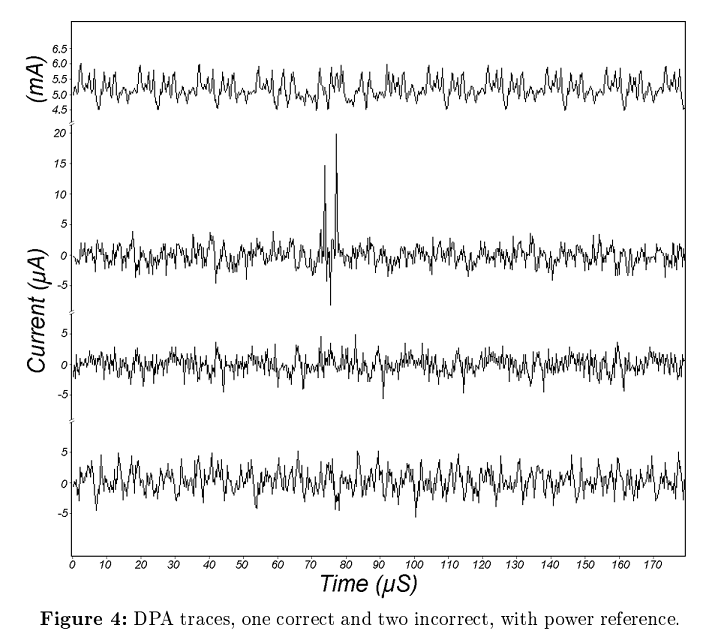

Even though DES was proven to be unsecure, and other more secure algorithms are in wide use, they are still succeptible to DPA if implemented without some kind of protection against this. In fact, the same principle will be used to attack the tinyAES implementation.

In [18]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tqdm.auto import trange

In [5]:
from utils.data_preparation import SCAML_Dataset

In [3]:
EXECUTE_IN_COLAB = False
ATTACK_ALGORITHM = 'tinyaes'

if EXECUTE_IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    colab_root_path = '/content/drive/MyDrive/'
    
    training_data_path = colab_root_path + 'datasets/tinyaes/train'
    testing_data_path = colab_root_path + 'datasets/tinyaes/test'
    
    save_models_root_path = colab_root_path + 'models/'
    
    log_root_path = colab_root_path + 'logs/'
else:
    data_root_path = './data/SCA_datasets/datasets/' + ATTACK_ALGORITHM
    
    training_data_path = data_root_path + '/train'
    testing_data_path = data_root_path + '/test'
    
    save_models_root_path = './models/'
    
    log_root_path = './logs/'

In [6]:
dataset = SCAML_Dataset()
shard_array = dataset.load_shards(training_data_path)

256it [00:04, 61.19it/s]


In [7]:
# Chose random key(shard) to attack

example_shard_index = random.randint(0,256)

example_shard = shard_array[example_shard_index]
true_key = example_shard['keys'][:,0]
print(f"True key in shard {example_shard_index} : {true_key}")

True key in shard 69 : [ 69 195 167 135 148  66 242 246 219 255 146 219 204  21  95  96]


### Define AES utility

In [8]:
AES_SBOX = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f 
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def process_aes(input_byte, key_byte):
  sbox_input = input_byte ^ key_byte
  return AES_SBOX[sbox_input]

In [10]:
# Check if process_aes function is working properly
# sub_bytes_out is already calculated in the provided dataset.

"""
    key --> XOR <-- plain
             |
             | <--- sub_bytes_in
           -----
           | S |
           -----
             | <--- sub_bytes_out
"""

for pt_idx, plaintext in enumerate(example_shard['pts'].transpose()):
    for byte_idx, pt_byte in enumerate(plaintext):
        assert(process_aes(pt_byte, true_key[byte_idx]) == example_shard['sub_bytes_out'].transpose()[pt_idx][byte_idx])

Pseudocode for the DPA attack algorithm is given in [this article](https://www.tandfonline.com/doi/pdf/10.1080/23742917.2016.1231523)

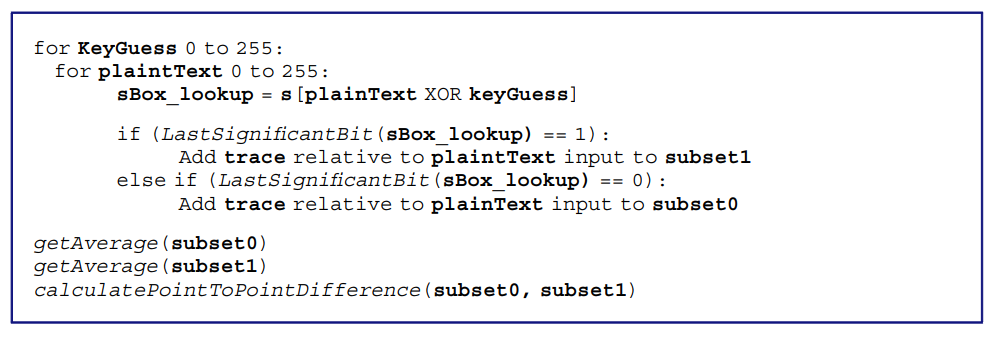

In [22]:
# Attack a single key byte
plotting_data = []
target_byte = 0
key_guesses = list(range(0, 256))
key_guess_predictions = 256*[0]

for key_guess in tqdm(range(256), position=0):
  
    ones  = []
    zeros = []

    for trace_idx, trace in enumerate(example_shard['traces']):

        # Calculate the AES SBOX output based on the key guess and known plaintext
        leak = process_aes(key_guess, example_shard['pts'].transpose()[trace_idx][target_byte])

        # Monitor the leakage on one output bit
        # Analogous to Selection function from DPA paper
        if (leak & (0x01 << 1)):
            ones.append(trace[:, 0])
        else:
            zeros.append(trace[:, 0])


    # print(f"Guess: {hex(key_guess)}")    
    ones_mean = np.asarray(ones).mean(axis=0)
    zeros_mean = np.asarray(zeros).mean(axis=0)
    mean_difference = abs(ones_mean - zeros_mean)

    plotting_data.append(mean_difference)

    # Look for the maximal difference => most possible leakage for this key guess
    key_guess_predictions[key_guess] = np.max(mean_difference)
  
    # print(f"Peak: {key_guess_predictions[key_guess]}")

    # If key is false -> half of the outputs will have 1 as first bit and half will have
    # 0 as first bit -> difference of means will be close to zero, and graph should appear flat
    # If key is correct -> there will be a spike either number of first bit == 0 is greater or number 
    # of first bit == 1 is greater and then the graph will spike in the areas where the target bit is processed

  0%|          | 0/256 [00:00<?, ?it/s]

KeyboardInterrupt: 

Define selection function for any of the target bits.

In [9]:
def DPA_selection_function(plaintext_byte, key_guess_byte, target_bit = 0):
    sbox_output = process_aes(plaintext_byte, key_guess_byte)

    if sbox_output & (0x01 << target_bit):
        return 1
    else:
        return 0

Maybe attacking some other bit will produce better results:

In [22]:
from tqdm.auto import tqdm

# Attack a single key byte
plotting_data = []
target_byte = 0
key_guesses = list(range(0, 256))
key_guess_predictions = 256*[0]
key_guess_predictions_loop = []
# key_guesses = [0x00, 0x01, 0x21, 0xA2, known_key[0]]
for key_guess in tqdm(range(0, 256), desc=f"Key guess: {hex(key_guess)}, actual key: {hex(known_key[target_byte])}", position=0):
  
    ones  = []
    zeros = []

    for trace_idx, trace in enumerate(tqdm(example_shard['traces'], desc="Inspecting traces", position=1, leave=False)):

        for tb in range(0,8):
            if(DPA_selection_function(key_guess, example_shard['pts'].transpose()[trace_idx][target_byte], target_bit=tb) == 1):
                ones.append(trace[:10000, 0])
            else:
                zeros.append(trace[:10000, 0])

        ones_mean_loop = np.asarray(ones).mean(axis=0)
        zeros_mean_loop = np.asarray(zeros).mean(axis=0)
        mean_difference_loop = abs(ones_mean_loop - zeros_mean_loop)

        key_guess_predictions_loop.append((key_guess, np.max(mean_difference_loop), tb))

    # print(f"Guess: {hex(key_guess)}")    
    ones_mean = np.asarray(ones).mean(axis=0)
    zeros_mean = np.asarray(zeros).mean(axis=0)
    mean_difference = abs(ones_mean - zeros_mean)

    plotting_data.append(mean_difference)

    # Look for the maximal difference => most possible leakage for this key guess
    key_guess_predictions[key_guess] = np.max(mean_difference)

Key guess: 0x0, actual key: 0x57:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice.


Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

Inspecting traces:   0%|          | 0/256 [00:00<?, ?it/s]

In [1]:
for g in key_guess_predictions_loop:
    if g[0] == 87:
        print(g)

NameError: ignored

In [23]:
max_mean_found = 0
max_mean_bit = -1
max_mean_guess = -1

correct_key_max_mean = 0
correct_key_bit = -1

for _guess, _max, _bit in key_guess_predictions_loop:
  if _max > max_mean_found:
    max_mean_found = _max
    max_mean_bit = _bit
    max_mean_guess = _guess

    if _guess == 40 and _max > correct_key_max_mean:
      correct_key_max_mean = _max
      correct_key_bit = _bit

print(f"Most likely across all: keyguess {hex(max_mean_guess)}, mean value: {max_mean_found},target_bit {max_mean_bit} ")
print(f"Most likely for correct key (first byte): {correct_key_max_mean}, {correct_key_bit}")

Most likely across all: keyguess 0x8a, mean value: 0.5966796875,target_bit 7 
Most likely for correct key (first byte): 0, -1


In [ ]:
guess_prediction_indices = np.argsort(key_guess_predictions)[::-1]
print(guess_prediction_indices)
predicted_key_values = np.asarray(key_guesses)[guess_prediction_indices]
print(f"Top 10 predicted key values: {[hex(x) for x in predicted_key_values[:10]]}")
print(f"Most likely key byte max mean: {key_guess_predictions[predicted_key_values[0]]}")
print(f"Correct key byte max mean: {key_guess_predictions[known_key[0]]}")

# Plot mean differences on a single graph => spike is expected for the correct key
plt.figure(figsize=(15, 5))
for data in np.asarray(plotting_data)[guess_prediction_indices]:
  plt.plot(data)

Cak i nakon isprobavanja razlicitih bitova, rezultati nisu nista bolji. Ovo je jedan od nedostataka DPA, odnosno za tacne rezultate je potreban veci broj zabelezenih power traceova (zbog racunanja proseka trace-ova). Jedan korak ka boljem resenju je CPA, ali i taj prisup ima ogranicenja koja ce biti pomenuta u narednom koraku.
* manji broj trace-va
* nije potrebno kompleksno preprocesiranje
* nije potrebna duboka ekspertiza
* ...

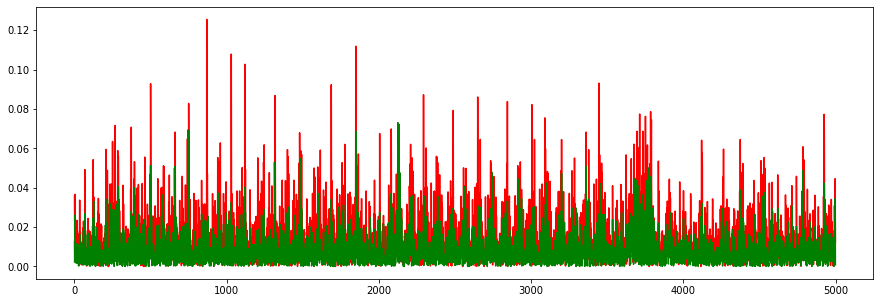

In [20]:
plt.figure(figsize=(15, 5))
plt.title('Mean differences graph')
plt.plot(plotting_data[predicted_key_values[0]], color='r', label='Predicted key')
plt.plot(plotting_data[known_key[0]], 'g', label='Correct key')
plt.legend(loc='best')
plt.show()

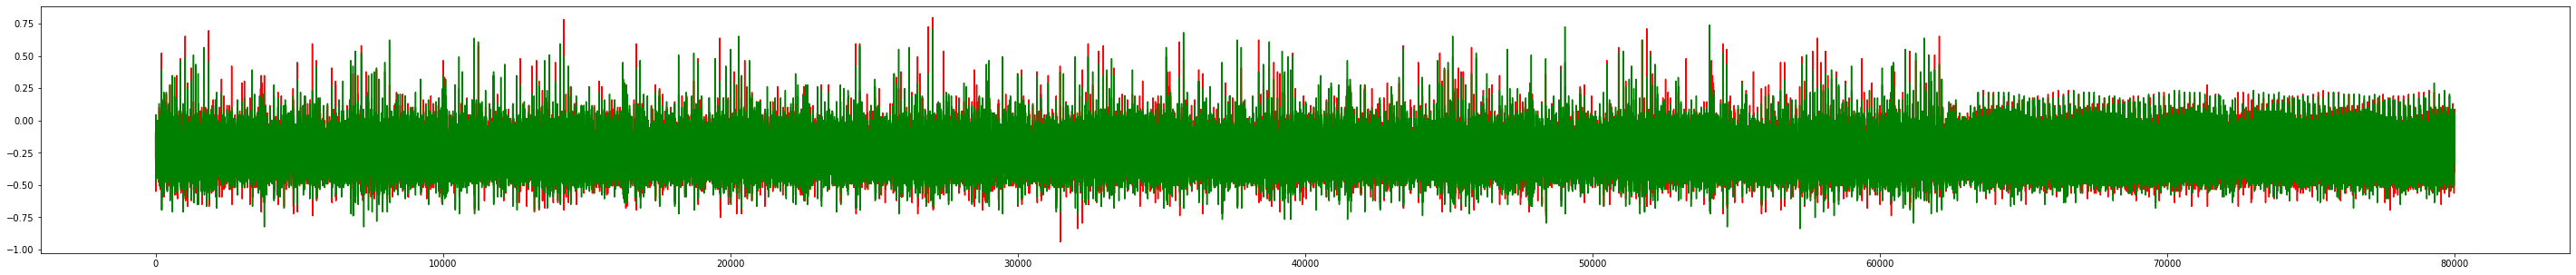

In [10]:
plt.figure(figsize=(50, 5))
plt.plot(example_shard['traces'][predicted_key_values[0]], 'r')
plt.plot(example_shard['traces'][known_key[0]], 'g')

Ocigledno je da dobijeni rezultati nisu jednoznacni i nisu dovoljno precizni. Jedan od razloga za ovo moze biti nedovoljan broj power traceova za jedan kljuc. 